In [1]:
%matplotlib inline
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt

In [2]:
images = sorted(glob.glob('images/frame_*.jpg'))
image = cv2.imread('images/QRcode.png')

qrDecoder = cv2.QRCodeDetector()

#imgQR = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

data, bbox, rectifiedImage = qrDecoder.detectAndDecode(image)
if len(data) > 0:
    print('Decoded Data : {}'.format(data))
    rectifiedImage = np.uint8(rectifiedImage);
    cv2.imshow('Rectified QR code', rectifiedImage);
else:
    print('QR code not detected')
    #cv2.imshow('Results', image)

cv2.waitKey(0)
cv2.destroyAllWindows

In [3]:
rows, columns, square_width = 6,9,27

In [4]:
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

objp = np.zeros((rows*columns, 3), np.float32)
objp[:, :2] = np.mgrid[0:columns, 0:rows].T.reshape(-1,2)

In [11]:
def compute_calibration(images, show=False):

    objectpts = []
    imagepts = []
    chessboard = []

    for i in images:
        img = cv2.imread(i)
        img = cv2.transpose(img)
        img = cv2.flip(img, 1)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        ret, corners = cv2.findChessboardCorners(gray, (columns, rows), flags=cv2.CALIB_CB_ACCURACY)

        if ret:
            objectpts.append(objp)

            corners2 = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
            imagepts.append(corners)

            img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
            cv2.drawChessboardCorners(img, (columns, rows), corners2, ret)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            chessboard.append(img)

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objectpts, imagepts, gray.shape[::-1], None, None)

    n = len(objectpts)
    error = 0
    for i in range(n):
        imagepts2, _ = cv2.projectPoints(objectpts[i], rvecs[i], tvecs[i], mtx, dist)
        error += cv2.norm(imagepts[i], imagepts2, cv2.NORM_L2)/(len(imagepts2))
    error /= n

    return error, mtx, dist, chessboard


Number of samples

9

Calibration error

0.1532282594251328

Camera matrix

[[3.11179616e+03 0.00000000e+00 1.51465650e+03]
 [0.00000000e+00 3.12540262e+03 1.99869532e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]

Distortion coefficients

[[-3.17439398e-02  6.21911206e-01  4.15053058e-04 -2.86502122e-03
  -2.40804555e+00]]

Set of images



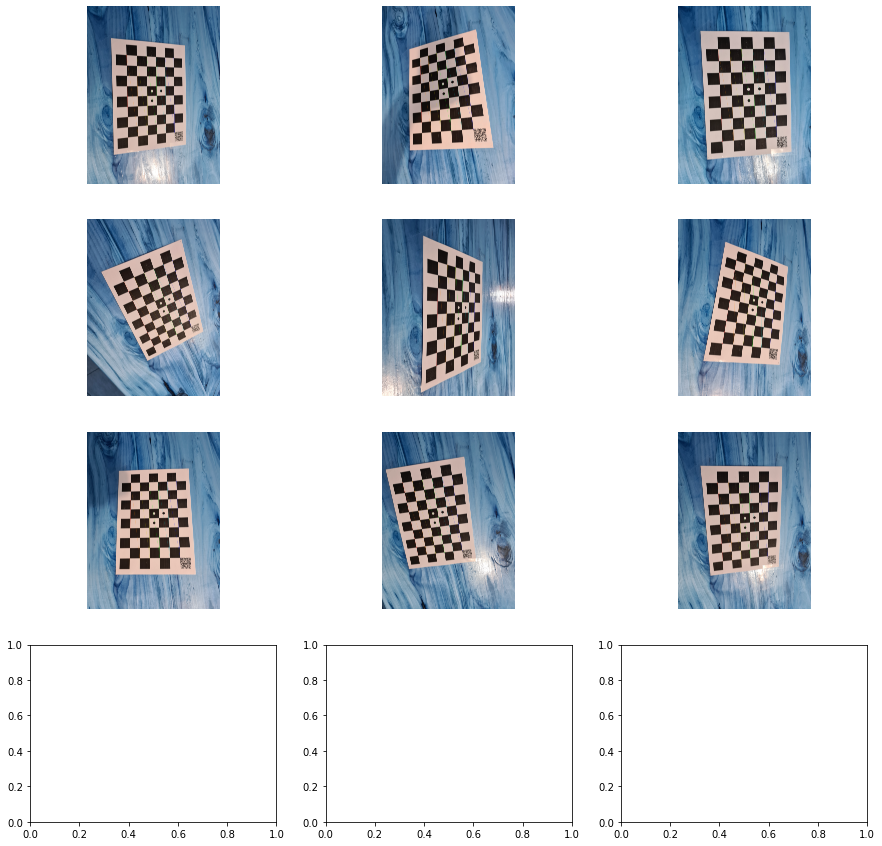

In [13]:
error, mtx, dist, chessboards = compute_calibration(images, show=True)

print("\nNumber of samples\n\n{0}".format(len(images)))
print("\nCalibration error\n\n{0}".format(error))
print("\nCamera matrix\n\n{0}".format(mtx))
print("\nDistortion coefficients\n\n{0}".format(dist))
print("\nSet of images\n")
index = 0
x, y = 4, 3
f, axarr = plt.subplots(x, y, figsize=(15,15))
for image in chessboards:
    axarr[index // y, index % y].axis('off')
    axarr[index // y, index % y].imshow(image, cmap='gray')
    index += 1